In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

import warnings
warnings.filterwarnings('ignore')

import lvm_read
import pyFRF

import pyidi
import pyEMA

%load_ext autoreload
%autoreload 2

Some settings and functions that will be used during presentation:

In [2]:
font_size = 15
figsize = (16.0, 8.0)
plt.style.use('ggplot')

def show_modal_data(nat_freq, damping):
    """Show modal data in a table-like structure."""
    print('   Nat. f.      Damping')
    print(23*'-')
    for i, f in enumerate(nat_freq):
        print(f'{i+1}) {f:6.1f}\t{damping[i]:5.4f}')

In [3]:
%matplotlib qt

In [4]:
%matplotlib qt

# A Hands-on Tutorial on Image-based Identification of Structural Dynamics

## Basic experimental skills

Location of the selected files:

In [5]:
cam_fname = "data/camera.cih"
cam_file = '.'.join(cam_fname.split('.')[:-1])

cam_fname_force = "data/camera.lvm"
acc_fname = "data/acceleration.lvm"

Load the video using ``pyidi`` package (developed by LADISK), accessible on [PyPI][1].

[1]: https://pypi.org/project/pyIDI/

The package enables calculation of displacements and will be upgraded with additional functionalities.

In [6]:
video = pyidi.pyIDI(cam_fname)

Images are stored in the ``mraw`` attribute.

In [7]:
time = np.linspace(0, 1, int(video.info['Total Frame']))
fig, ax = plt.subplots(figsize=(17, 5))
def show(i):
    ax.clear()
    ax.imshow(video.mraw[i], cmap='gray')
    ax.text(10, -10, f'time = {time[i]:5.4f} s')
    ax.text(10, -30, f'frame = {i}')
    ax.grid(False)
    
    axins = zoomed_inset_axes(ax, 3, loc=8)
    axins.imshow(video.mraw[i, ::-1], cmap='gray')
    axins.set_xlim([400, 450])
    axins.set_ylim([1, 39])
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    axins.grid(False)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="r", lw=2)
    plt.tight_layout()

FuncAnimation(fig, show, frames=np.arange(0, 1000, 25))

In [8]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = figsize
matplotlib.rcParams['font.size'] = font_size

### Acquisition parameters

The parameters that were used when recording can be found in the ``info`` attribute:

In [9]:
video.info

OrderedDict([('Date', '2018/12/17'),
             ('Camera Type', 'FASTCAM SA-Z type 2100K-M-64GB'),
             ('Record Rate(fps)', '15000'),
             ('Shutter Speed(s)', '1/15371'),
             ('Total Frame', '3750'),
             ('Image Width', '640'),
             ('Image Height', '40'),
             ('Color Bit', '8'),
             ('File Format', 'MRaw'),
             ('EffectiveBit Depth', '12')])

### Lighting
Lighting conditions are very important when using high-speed camera. To obtain optimal lighting conditions, a histogram of pixel intensity is viewd. An example of a well balanced historgram is shown.

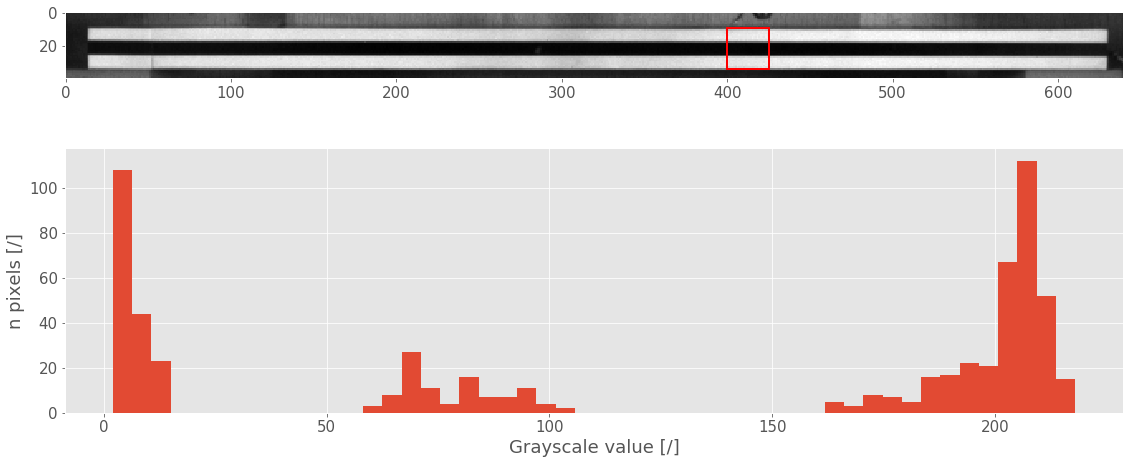

In [10]:
x0 = 400
y0, d = 9, 25
roi = video.mraw[0, y0:y0+d, x0:x0+d]

fig, ax = plt.subplots(2)
ax[0].imshow(video.mraw[0], cmap='gray')
ax[1].hist(roi.flatten(), bins=50);
# Formating
ax[0].add_patch(patches.Rectangle((x0, y0), d, d, fill=False, color='r', linewidth=2))
ax[0].grid(False)
ax[1].set_xlabel('Grayscale value [/]')
ax[1].set_ylabel('n pixels [/]')
plt.tight_layout()

### Surface preperation
In order for gradient-based methods to work, sufficient gradient must be present on the images. Surface preperations is therefor necessary.

In [11]:
grad0, grad1 = np.gradient(video.mraw[0].astype(float)) # gradient computation

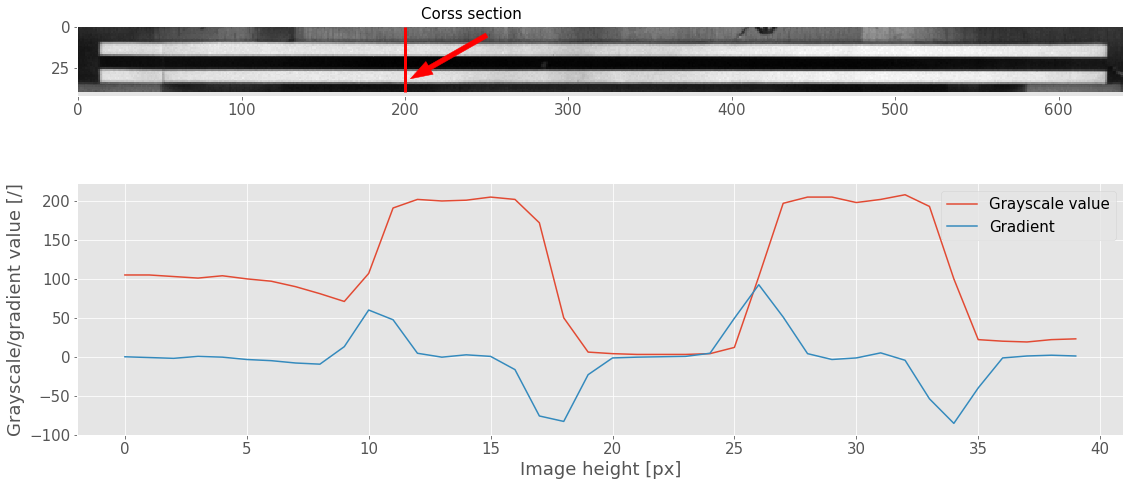

In [12]:
x0 = 200

fig, ax = plt.subplots(2)
ax[0].imshow(video.mraw[0], cmap='gray')
ax[1].plot(video.mraw[0, :, x0], label='Grayscale value')
ax[1].plot(grad0[:, x0], label='Gradient')
# Formating
ax[0].vlines(x0, 0, 40, colors='r', linewidth=3)
ax[0].text(x0+10, -5, 'Corss section')
ax[0].arrow(x0+50, 5, -35, 20, color='r', width=3)
ax[0].grid(False)
ax[1].set_xlabel('Image height [px]')
ax[1].set_ylabel('Grayscale/gradient value [/]')
plt.legend()
plt.tight_layout()

### Possible errors

#### Out of focus image

In [13]:
layout_fname = r"data/focus.cih"
video_layout = pyidi.pyIDI(layout_fname)

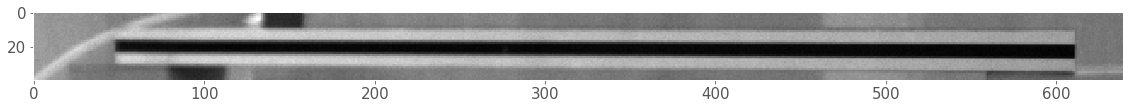

In [14]:
fig, ax = plt.subplots()
ax.imshow(video_layout.mraw[0], 'gray')

# Formating
ax.grid(False)
plt.tight_layout()

#### Improper lighting

In [15]:
light_fname = r"data/illumination.cih"
video_light = pyidi.pyIDI(light_fname)

In [16]:
y0, d = 9, 20

def show(x0):
    roi = video_light.mraw[0, y0:y0+d, x0:x0+d*2]
    fig, ax = plt.subplots(2)
    ax[0].imshow(video_light.mraw[0], cmap='gray')
    ax[1].hist(roi.flatten(), bins=50);
    # Formating
    ax[0].add_patch(patches.Rectangle((x0, y0), d*2, d, fill=False, color='r', linewidth=2))
    ax[0].grid(False)
    ax[1].set_xlabel('Grayscale value [/]')
    ax[1].set_ylabel('n pixels [/]')
    ax[1].set_xlim([0, 260])
    plt.tight_layout()
interact(show, x0=(75, 550, 50))

interactive(children=(IntSlider(value=275, description='x0', max=550, min=75, step=50), Output()), _dom_classe…

<function __main__.show(x0)>

## Simplified Optical-flow Method

Basic formulation:
$$
s(x_j,y_k,t)=\frac{I_0(x_j,y_k)-I(x_j,y_k,t)}{|\nabla I_0|}
$$

As used by [Javh et al.][1] ([pdf][2])

[1]: https://www.sciencedirect.com/science/article/pii/S0888327016304770
[2]: http://lab.fs.uni-lj.si/ladisk/?what=abstract&ID=179

First, the reference image must be computed:

In [17]:
reference_image = np.average(video.mraw[:500], axis=0)

and gradients in ``x`` (1) and ``y`` (0) directions:

In [18]:
grad0, grad1 = np.gradient(reference_image)

Points with the highest absolute value of gradient in **vertical** direction are determined:

In [19]:
border = 20
border_h = 12
n = 2
N = 20
w = np.arange(border, reference_image.shape[1]-border, np.abs(border - reference_image.shape[1]-border)//N)
h = np.argsort(np.abs(grad0[border_h:-border_h, w]), axis=0)[-n:, :].T + border_h
inds = np.column_stack((h.flatten(), w.repeat(n)))

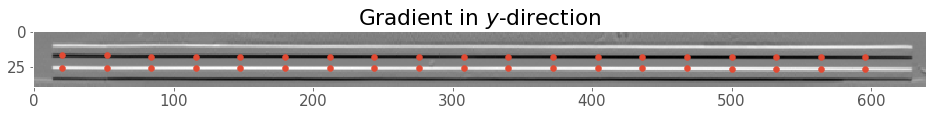

In [20]:
fig, ax = plt.subplots()
ax.imshow(grad0, cmap='gray')
ax.scatter(inds[:, 1], inds[:, 0])
ax.grid(False)
ax.set_title('Gradient in $y$-direction');

Displacement computation, implemented in ``pyIDI``:

In [21]:
video.set_points(
    inds, 
    n=n) # selecting points for analysis

``get_displacements()`` method computes the displacements.

In [22]:
displacements = video.get_displacements(
    mean_n_neighbours=n, 
    convert_from_px=4.86 * 1e-4,
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:02<00:00, 1337.54it/s]


Averaging...
Finished!


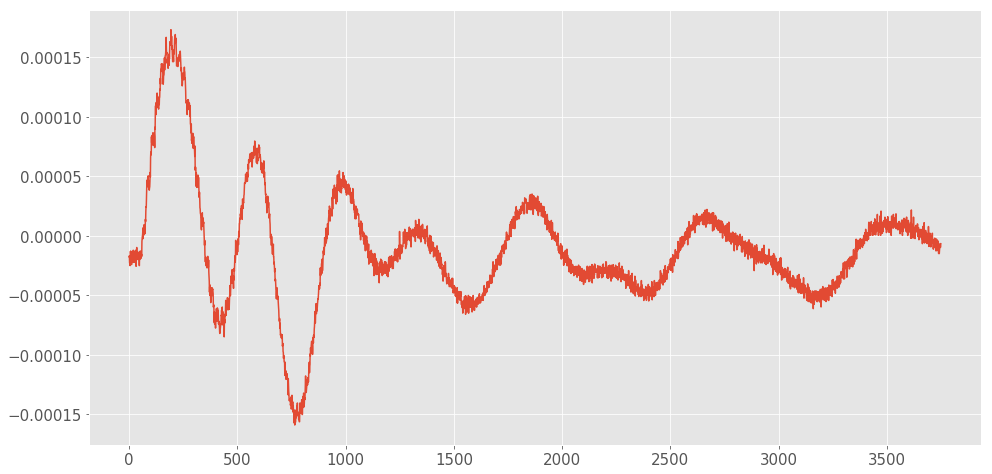

In [23]:
fig, ax = plt.subplots()
ax.plot(displacements[:, 10]);

## Frequency Response Functions

In [24]:
upper_f_limit = 3500

Frequency response functions are built. First the FFT of displacments is computed:

In [25]:
N = int(video.info['Total Frame'])
T = 0.25 # s
dt = T/N
freq_cam = np.fft.rfftfreq(N, dt)
fft_cam = np.fft.rfft(displacements.T, N) *2/N

fft_cam = np.copy(fft_cam[:, freq_cam<upper_f_limit])
freq_cam = np.copy(freq_cam[freq_cam<upper_f_limit])

where only the frequency range below `upper_f_limit` Hz was used.  The FFT of force measurement is determined:

In [26]:
lvm = lvm_read.read(cam_fname_force)
force_cam = lvm[0]['data'][:-30, 1] # 30 pre-samples
N = len(force_cam)//4 # force was captured for 1 second
dt = lvm[0]['Delta_X'][1]

fft_force_cam = np.fft.rfft(force_cam, N) *2/N
freq_force_cam = np.fft.rfftfreq(N, dt)

fft_force_cam = np.copy(fft_force_cam[freq_force_cam<upper_f_limit])
freq_force_cam = np.copy(freq_force_cam[freq_force_cam<upper_f_limit])

Since only one measurement was used, the FRF is determined by:

In [27]:
frf_cam = fft_cam/fft_force_cam

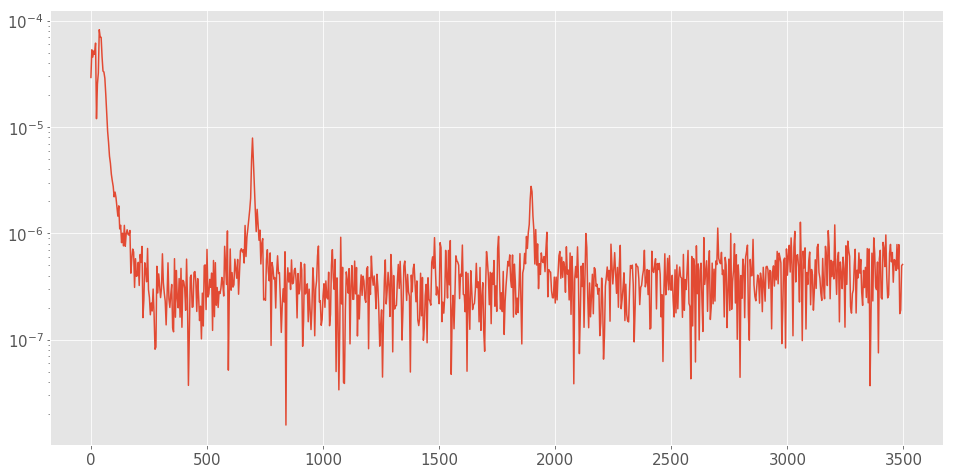

In [28]:
plt.semilogy(freq_cam, np.abs(frf_cam[0]));

## Modal Analysis - Only camera data

Modal analysis can be made using ``pyEMA`` package (developed by LADISK), accessible on [PyPI][1].

[1]: https://pypi.org/project/pyEMA/

In [29]:
cam = pyEMA.lscf(frf_cam, freq_cam, pol_order_high=75)

Poles are computed:

In [30]:
cam.get_poles(show_progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 56.39it/s]


Stable poles can be picked in the stability chart, or preditermind by passing in approximate natural frequencies.

In [31]:
# cam.stab_chart(cam.all_poles)
approx = [694, 1897]
cam.identification(approx)

In [32]:
show_modal_data(cam.nat_freq, cam.nat_xi)

   Nat. f.      Damping
-----------------------
1)  695.6	0.0013
2) 1897.7	-0.0009


After the stable poles are determind, a ``lsfd`` method can be called to reconstruct the FRF:

In [33]:
frf_rec, modal_const = cam.lsfd(FRF_ind='all')

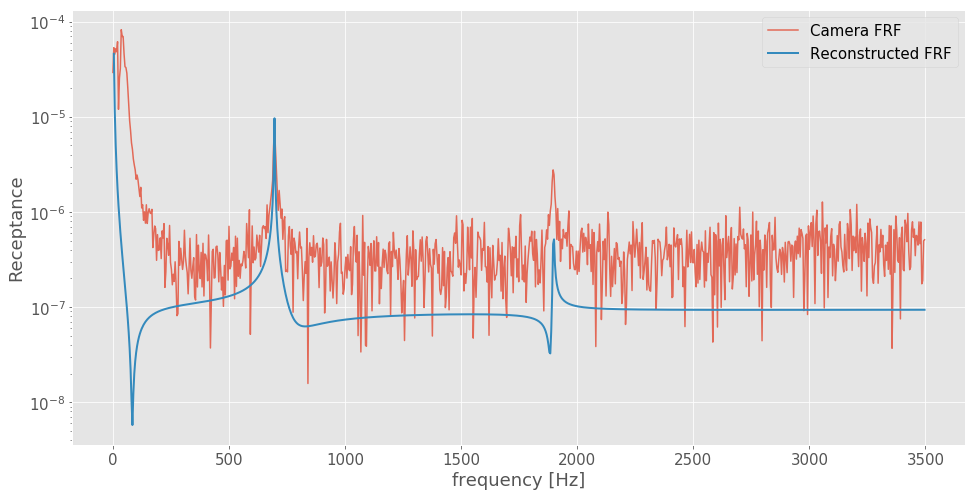

In [34]:
location = 0

fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[location]), label='Camera FRF', alpha=0.8)
ax.semilogy(freq_cam, np.abs(frf_rec[location]), label='Reconstructed FRF', lw=2)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Receptance')
plt.legend();

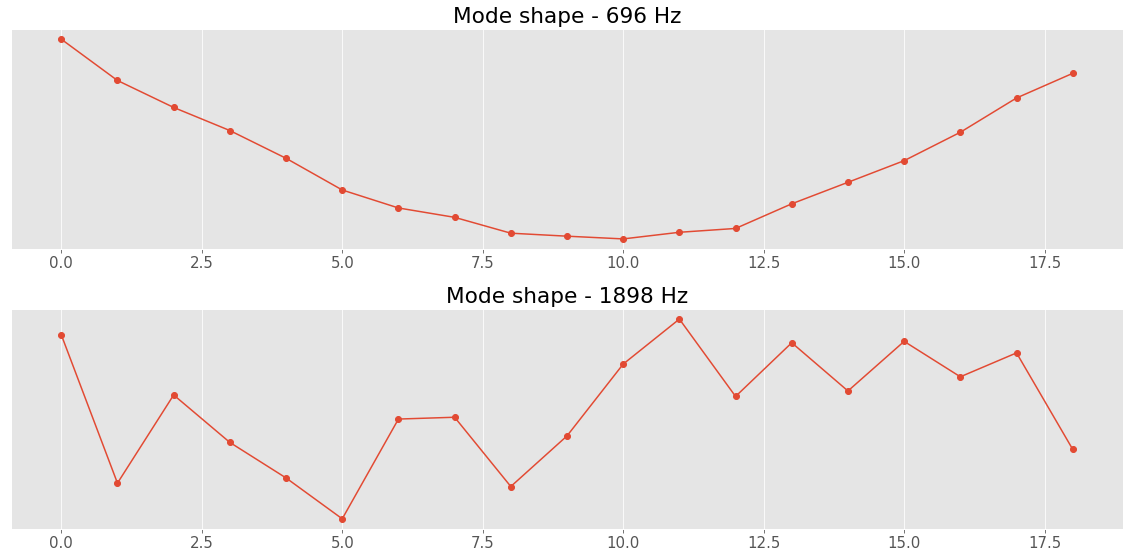

In [35]:
fig, ax = plt.subplots(modal_const.shape[1]-2)
for i, a in enumerate(ax):
    a.plot(modal_const[:, i], 'o-')
    a.set_title(f'Mode shape - {cam.nat_freq[i]:.0f} Hz')
    a.set_yticks([])
plt.tight_layout()

## Modal Analysis - Hybrid method

Hybrid method was developed by Javh et al. Further details can be found in [article][1] ([pdf][2])

First, the acceleration and force data are needed:

[1]: https://www.sciencedirect.com/science/article/pii/S0888327017302637
[2]: http://lab.fs.uni-lj.si/ladisk/?what=abstract&ID=192

In [36]:
lvm_acc = lvm_read.read(acc_fname)
dt_acc = lvm_acc[0]['Delta_X'][0]
acc_acc = lvm[0]['data'][:-30, 0] * 9.81
acc_force = lvm[0]['data'][:-30, 1]

The FRF can be computed using ``pyFRF`` package (developed py LADISK), accessible on [PyPI][1].

[1]: https://pypi.org/project/pyFRF/

In [37]:
import pyFRF

frf_ = pyFRF.FRF(
    sampling_freq=1/dt_acc,
    exc=acc_force,
    resp=acc_acc,
    exc_window='None',
    resp_type='a',
    resp_window='None')

Only the frequencies lower than `upper_f_limit` Hz are observed:

In [38]:
freq_acc = frf_.get_f_axis()
frf_acc = frf_.get_FRF(form='receptance')

frf_acc = frf_acc[freq_acc<upper_f_limit]
freq_acc = freq_acc[freq_acc<upper_f_limit]

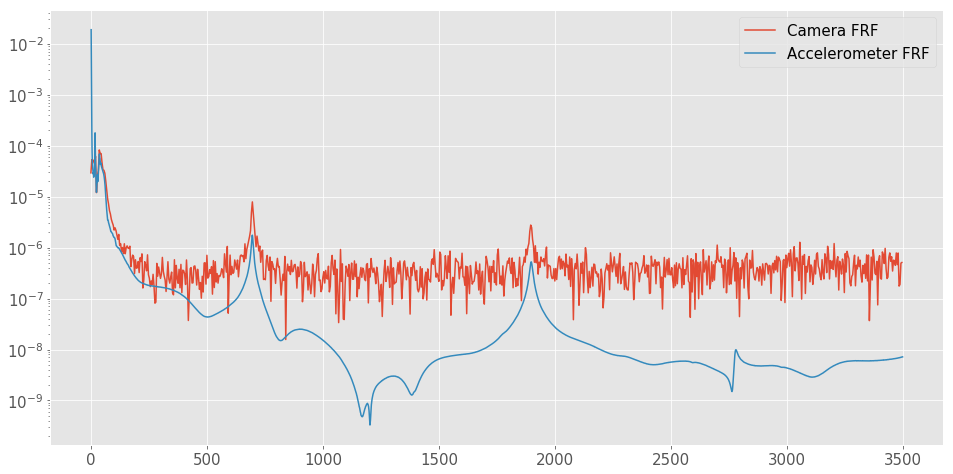

In [39]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[0]), label='Camera FRF')
ax.semilogy(freq_acc, np.abs(frf_acc), label='Accelerometer FRF')
plt.legend();

Next the ``lscf`` object can be created and poles are computed for the hybrid method:

In [40]:
acc = pyEMA.lscf(frf_acc[1:], freq_acc[1:], pol_order_high=50)

In [41]:
acc.get_poles(show_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 419.77it/s]


In [42]:
# acc.stab_chart(acc.all_poles)
approx = [695, 1898]
acc.identification(approx)

In [43]:
show_modal_data(acc.nat_freq, acc.nat_xi)

   Nat. f.      Damping
-----------------------
1)  695.0	0.0046
2) 1897.7	0.0031


The poles computed based on accleration data are more reliable. These poles can now be used in reconstruction of FRFs from camera. A new ``lscf`` object is made with camera FRF:

In [44]:
cam_hyb = pyEMA.lscf(frf_cam, freq_cam)

Next, the reconstruction is done using accleration-determined poles:

In [45]:
frf_hyb, A_hyb = cam_hyb.lsfd(whose_poles=acc, FRF_ind='all')

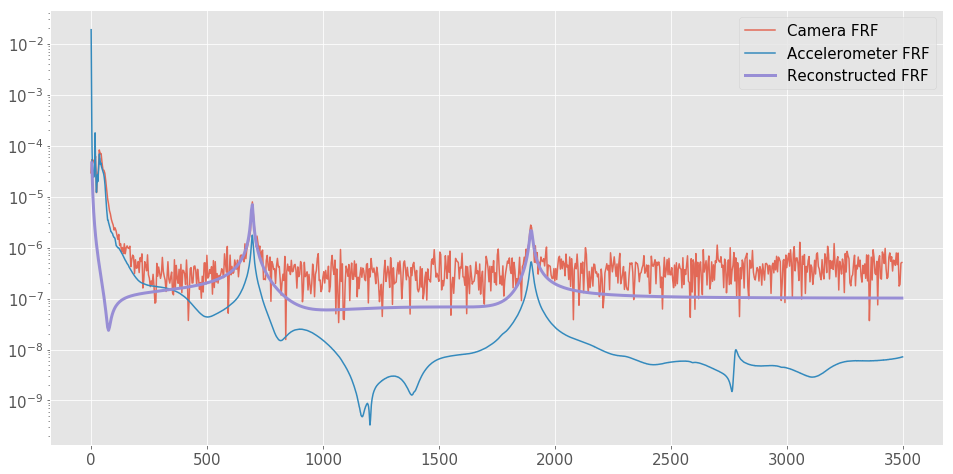

In [46]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[0]), label='Camera FRF', alpha=0.8)
ax.semilogy(freq_acc, np.abs(frf_acc), label='Accelerometer FRF')
ax.semilogy(freq_cam, np.abs(frf_hyb[0]), label='Reconstructed FRF', lw=3)
plt.legend();

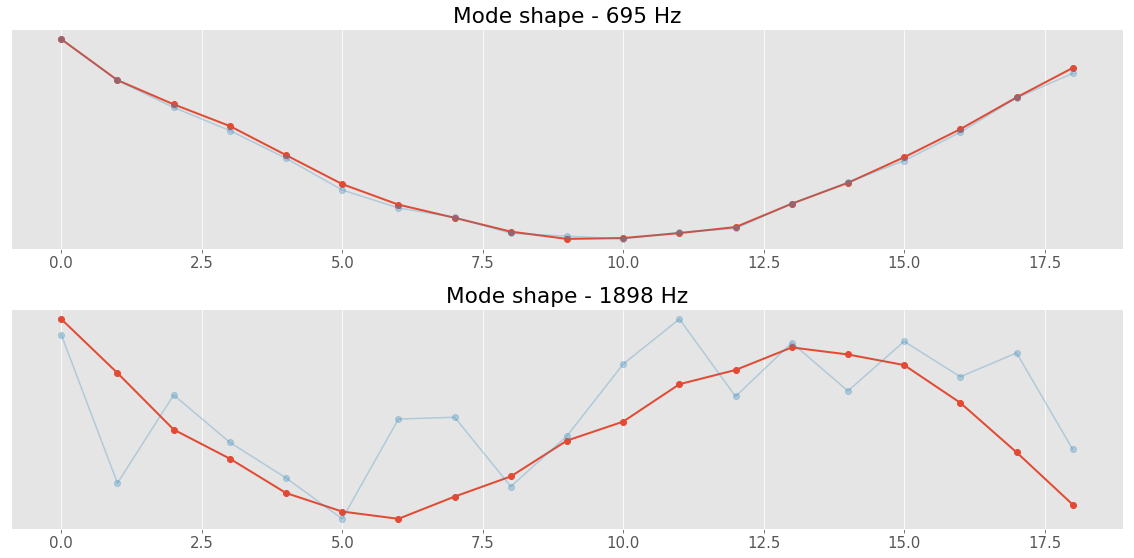

In [47]:
fig, ax = plt.subplots(A_hyb.shape[1]-2)
for i, a in enumerate(ax):
    a.plot(A_hyb[:, i], 'o-', lw=2)
    a_ = a.twinx()
    a_.plot(modal_const[:, i], 'C1o-', alpha=0.3)
    a.set_title(f'Mode shape - {acc.nat_freq[i]:.0f} Hz')
    a.set_yticks([])
    a_.set_yticks([])
plt.tight_layout()